In [1]:
import os
from time import time as ptime
import pickle

import numpy as np

from astropy.time import Time
from astropy import table
from astropy import units as u
from astropy.coordinates import SkyCoord, ICRS, get_sun

import tqdm

In [2]:
import astroquery
from astroquery import mast
from astroquery.mast import Observations

In [3]:
%matplotlib inline

from matplotlib import pyplot as plt

In [4]:
#coll = Observations.query_criteria_async(obs_collection='HST')  #FAILS

Above fails because it's too many rows.  Try one year at a time:

In [5]:
os.getpid()

28102

In [8]:
now = Time.now()
t0 = Time('1990-1-1')

# comment these out to resume after a failure
#currtime = t0
#colls = []

tq = tqdm.tqdm_notebook()
while currtime < now:
    t2 = currtime + 1*u.year
    nerr = 0
    while True:
        try:
            coll1 = Observations.query_criteria(obs_collection='HST', 
                                                t_min=[currtime.mjd, t2.mjd])
            colls.append(coll1)
            break
        except ConnectionError:  # this spontaneous happens but resolves usually the second/third time
            if nerr > 10:
                raise
                
    currtime = t2
    tq.update(1)
    
    deltat = ptime()-tq.start_t
    nsofar = np.sum([len(coll) for coll in colls])
    print(currtime.datetime, 'dt:', deltat, 'per sec:', nsofar/deltat, 't left:', (512000-nsofar)*deltat/nsofar)


1999-01-01 05:59:53 dt: 184.99320793151855 per sec: 675.1815452934759 t left: 573.3213573421116
2000-01-01 11:59:53 dt: 273.3917179107666 per sec: 546.0479971405927 t left: 664.2547942660261
2000-12-31 17:59:53 dt: 343.07360100746155 per sec: 501.3705499195754 t left: 678.1271856804076
2001-12-31 23:59:53 dt: 443.86331486701965 per sec: 443.3910021578654 t left: 710.8736949239616
2003-01-01 05:59:53 dt: 549.6226949691772 per sec: 411.22937984334004 t left: 695.4245343777363
2004-01-01 11:59:53 dt: 722.6653459072113 per sec: 364.38442979360843 t left: 682.4440883515541
2004-12-31 17:59:53 dt: 842.2220637798309 per sec: 346.24835009811994 t left: 636.4853433598979
2005-12-31 23:59:53 dt: 906.909353017807 per sec: 341.99669345995824 t left: 590.1811446128262
2007-01-01 05:59:52 dt: 971.1531698703766 per sec: 331.859082582222 t left: 571.670356356741
2008-01-01 11:59:52 dt: 1016.0368568897247 per sec: 332.549944137186 t left: 523.5815042812695
2008-12-31 17:59:52 dt: 1103.9724979400635 pe

In [14]:
nsofar

512075

In [18]:
colls[0]

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
str10,int64,str3,str9,str16,float64,float64,float64,float64,float64,str7,str9,float64,float64,str68,str119,float64,str8,str20,str4,str8,str3,str844,str34,str35,str6,bool,float64,str7,str10,str10
image,2,HST,x14w0401t,3C277.3,193.5504662318,27.62522325764,48005.9708224,48005.981239,899.9942401656881,Optical,F410M,4.003e-07,4.197e-07,GALAXY;ELLIPTICAL;RADIO GALAXY;NLR;,HIGH-SPATIAL-RESOLUTION IMAGING AND SPECTROSCOPY OF AGN: CYCLE 2,49396.01032,FOC,"Macchetto, F. Duccio",3504,AUG/FOC,HST,POLYGON GSC1 193.55009800 27.62309600 193.54803800 27.62535500 193.55082500 27.62735100 193.55288500 27.62509200,mast:HST/product/x14w0401t_c0f.jpg,mast:HST/product/x14w0401t_c0f.fits,PUBLIC,False,--,science,2003786834,2018999492
image,2,HST,x14w0402t,3C277.3,193.5504662318,27.62522325764,48005.9708224,48005.981239,899.9942401656881,Optical,F410M,4.003e-07,4.197e-07,GALAXY;ELLIPTICAL;RADIO GALAXY;NLR;,HIGH-SPATIAL-RESOLUTION IMAGING AND SPECTROSCOPY OF AGN: CYCLE 2,49396.01323,FOC,"Macchetto, F. Duccio",3504,AUG/FOC,HST,POLYGON GSC1 193.55009800 27.62309600 193.54803800 27.62535500 193.55082500 27.62735100 193.55288500 27.62509200,mast:HST/product/x14w0402t_c0f.jpg,mast:HST/product/x14w0402t_c0f.fits,PUBLIC,False,--,science,2003786835,2018999494
image,2,HST,x14w0403t,3C277.3,193.5504662318,27.62522325764,48005.9708224,48005.981239,899.9942401656881,UV,F320W,2.938e-07,3.782e-07,GALAXY;ELLIPTICAL;RADIO GALAXY;NLR;,HIGH-SPATIAL-RESOLUTION IMAGING AND SPECTROSCOPY OF AGN: CYCLE 2,49395.97274,FOC,"Macchetto, F. Duccio",3504,AUG/FOC,HST,POLYGON GSC1 193.55009800 27.62309600 193.54803800 27.62535500 193.55082500 27.62735100 193.55288500 27.62509200,mast:HST/product/x14w0403t_c0f.jpg,mast:HST/product/x14w0403t_c0f.fits,PUBLIC,False,--,science,2003786836,2018999496
image,2,HST,x14w0404t,3C277.3,193.5504662318,27.62522325764,48005.9708224,48005.981239,899.9942401656881,UV,F320W,2.938e-07,3.782e-07,GALAXY;ELLIPTICAL;RADIO GALAXY;NLR;,HIGH-SPATIAL-RESOLUTION IMAGING AND SPECTROSCOPY OF AGN: CYCLE 2,49395.97676,FOC,"Macchetto, F. Duccio",3504,AUG/FOC,HST,POLYGON GSC1 193.55009800 27.62309600 193.54803800 27.62535500 193.55082500 27.62735100 193.55288500 27.62509200,mast:HST/product/x14w0404t_c0f.jpg,mast:HST/product/x14w0404t_c0f.fits,PUBLIC,False,--,science,2003786837,2018999498
image,2,HST,x14w0405t,3C277.3,193.5504662318,27.62522325764,48005.9708224,48005.981239,899.9942401656881,Optical,F550M,5.366e-07,5.554e-07,GALAXY;ELLIPTICAL;RADIO GALAXY;NLR;,HIGH-SPATIAL-RESOLUTION IMAGING AND SPECTROSCOPY OF AGN: CYCLE 2,49395.98006,FOC,"Macchetto, F. Duccio",3504,AUG/FOC,HST,POLYGON GSC1 193.55009800 27.62309600 193.54803800 27.62535500 193.55082500 27.62735100 193.55288500 27.62509200,mast:HST/product/x14w0405t_c0f.jpg,mast:HST/product/x14w0405t_c0f.fits,PUBLIC,False,--,science,2003786838,2018999500
image,2,HST,x14w0406t,3C277.3,193.5504662318,27.62522325764,48005.9708224,48005.981239,899.9942401656881,Optical,F550M,5.366e-07,5.554e-07,GALAXY;ELLIPTICAL;RADIO GALAXY;NLR;,HIGH-SPATIAL-RESOLUTION IMAGING AND SPECTROSCOPY OF AGN: CYCLE 2,49395.98336,FOC,"Macchetto, F. Duccio",3504,AUG/FOC,HST,POLYGON GSC1 193.55009800 27.62309600 193.54803800 27.62535500 193.55082500 27.62735100 193.55288500 27.62509200,mast:HST/product/x14w0406t_c0f.jpg,mast:HST/product/x14w0406t_c0f.fits,PUBLIC,False,--,science,2003786839,2018999502
image,2,HST,x1680b01t,0103+005,16.58006776375,0.8063868994272,48005.9708224,48005.9784613,660.0009602028877,UV,F170M,1.668e-07,1.852e-07,GALAXY;QSO;QUASAR;,"SEARCH FOR QSOS SUITABLE FOR SUBSEQUENT OBSERVATION OF HE II 304 ABSORPTION ARISING IN THE IGM, LY-ALPHA, AND ... PART2",49401.91669,FOC,"Tytler, David R.",4107,SNAP,HST,POLYGON GSC1 16

In [24]:
allobs = table.vstack([tc['t_min', 't_max', 's_ra', 's_dec'] for tc in colls])
#del colls
len(allobs)

512075

In [26]:
#save with:
#dct = {nm:allobs[nm] for nm in ['t_min', 't_max', 's_ra', 's_dec']}
#np.savez('subdata', **dct)

# restore with:
# allobs = np.load('subdata.npz')

In [27]:
ts = Time((allobs['t_min'] + allobs['t_max'])/2, format='mjd')

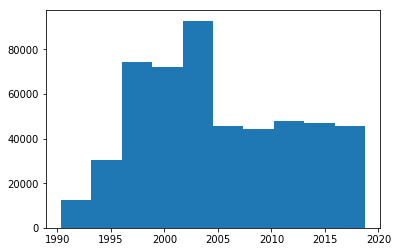

In [28]:
plt.hist(ts.jyear);

In [29]:
validra = (0<=allobs['s_ra'])&(allobs['s_ra']<=360)
validdec = (-90<allobs['s_dec'])&(allobs['s_dec']<90)
msk = validra&validdec
np.sum(msk)

/Users/erik/miniconda3/envs/astro36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/astro36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/astro36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/erik/miniconda3/envs/astro36/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


512059

In [30]:
sc = SkyCoord(ra=allobs['s_ra'][msk], 
              dec=allobs['s_dec'][msk], 
              unit=u.deg)
tsm = ts[msk]
delyear = tsm.jyear - np.floor(tsm.jyear)

In [31]:
from astropy.coordinates import UnitSphericalRepresentation, CartesianRepresentation
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product

def circle_around(ra_cen, dec_cen, rad, n=100, ax=None, **kwargs):
    usr = UnitSphericalRepresentation(np.linspace(0, 360, n)*u.deg, np.ones(n)*(90*u.deg-rad))
    r2 = rotation_matrix(dec_cen-90*u.deg, 'y')
    r1 = rotation_matrix(-ra_cen, 'z')
    cr = CartesianRepresentation(matrix_product(r1, r2, usr.to_cartesian().xyz))
    usr2 = cr.represent_as(UnitSphericalRepresentation)
    if ax is not None:
        ax.plot(usr2.lon.wrap_at(180*u.deg).rad, usr2.lat.rad, **kwargs)
    else:
        assert len(kwargs)==0, 'cannot give plot kwargs if ax is None'
    return usr2

/Users/erik/miniconda3/envs/astro36/lib/python3.6/site-packages/matplotlib/projections/geo.py:353: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1 - (x / 4) ** 2 - (y / 2) ** 2)


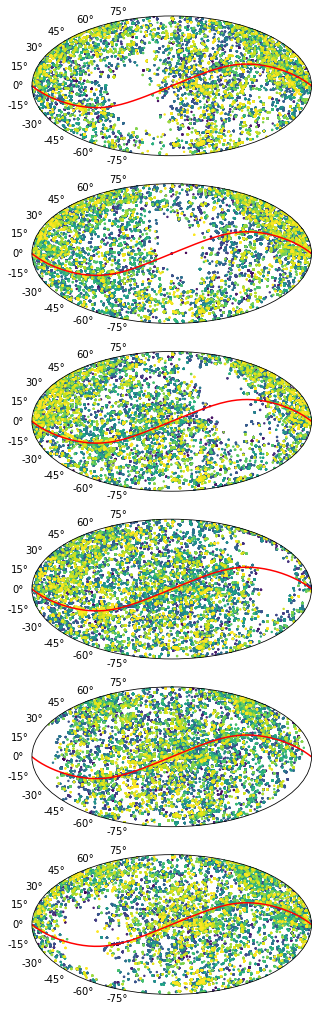

In [32]:
fig, axs = plt.subplots(6, 1, subplot_kw={'projection': 'hammer'}, figsize=(6, 18))

for i, ax in enumerate(axs.ravel()):
    dyrst = i/6
    dyrend = (i+1)/6

    sample = (dyrst<delyear)&(delyear<dyrend)

    ax.scatter(sc.ra.wrap_at(180*u.deg).rad[sample], 
               sc.dec.rad[sample],
               c=tsm.jyear[sample],
               s=2)
    
    sunpath_ra = np.linspace(-np.pi, np.pi, 100)
    ax.plot(sunpath_ra, (23.5*u.deg).to(u.rad)*np.sin(sunpath_ra), c='r')
    
    ax.set_xticks([])

There's the sun!  It's really pretty obvious!

Verify that the real avoidance angle is ~50 if you make the time bins small enough

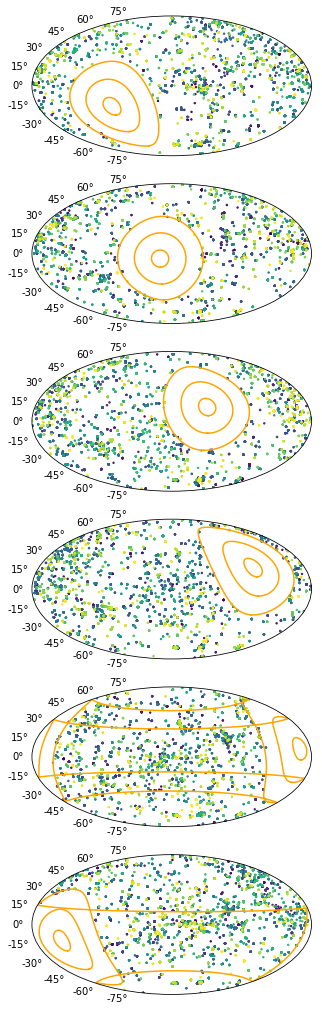

In [33]:
fig, axs = plt.subplots(6, 1, subplot_kw={'projection': 'hammer'}, figsize=(6, 18))

for i, ax in enumerate(axs.ravel()):
    dyrst = i/6
    dyrend = i/6 + 1/50

    sample = (dyrst<delyear)&(delyear<dyrend)

    ax.scatter(sc.ra.wrap_at(180*u.deg).rad[sample], 
               sc.dec.rad[sample],
               c=tsm.jyear[sample],
               s=2)
    
    sun = get_sun(Time('2000-1-1') + (dyrst+dyrend)*0.5*u.year)
    circle_around(sun.ra, sun.dec, 10*u.deg, ax=ax, c='orange')
    circle_around(sun.ra, sun.dec, 30*u.deg, ax=ax, c='orange')
    circle_around(sun.ra, sun.dec, 50*u.deg, ax=ax, c='orange')
    
    ax.set_xticks([])

Now can we infer a period from the timings of the bins?

In [34]:
from astropy.stats import LombScargle

(0, 0.005)

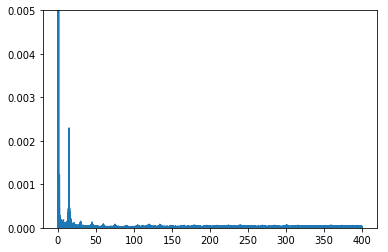

In [35]:
frequency, power = LombScargle(tsm.mjd, sc.ra.deg).autopower(maximum_frequency=400)
plt.plot(frequency, power)  
plt.ylim(0, .005)

(0, 0.0005)

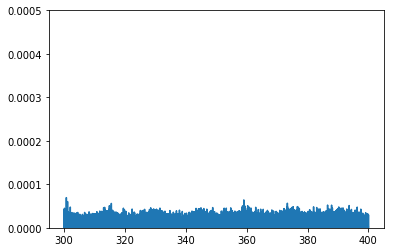

In [37]:
frequency2, power2 = LombScargle(tsm.mjd, sc.ra.deg).autopower(minimum_frequency=300, maximum_frequency=400)
plt.plot(frequency2, power2)  
plt.ylim(0, .0005)

No obvious signal in the power spectrum... probably because it's a "hole"

In [ ]:
plt.figure(figsize=(10, 10))
plt.hexbin(delyear, sc.ra.deg, bins='log')
plt.xlabel(r'$\Delta {\rm yr}$', fontsize=18)
plt.ylabel(r'$\alpha$', fontsize=18)

plt.figure(figsize=(10, 10))
plt.hexbin(delyear, sc.dec.deg, bins='log')
plt.xlabel(r'$\Delta {\rm yr}$', fontsize=18)
plt.ylabel(r'$\delta$', fontsize=18);

In [ ]:
plt.figure(figsize=(15, 6))
plt.hexbin(tsm.mjd, sc.ra.deg, bins='log', gridsize=(400, 50))
plt.xlabel(r'mjd', fontsize=18)
plt.ylabel(r'$\alpha$', fontsize=18)

Maybe look for periodicity in the fixed-RA signal?

In [ ]:
n, bins, _ = plt.hist(sc.ra.deg, bins=20)

In [100]:
argmax = np.argmax(n)
inrabin = (bins[argmax] < sc.ra.deg) & (sc.ra.deg < bins[argmax+1])

np.sum(inrabin)

49484

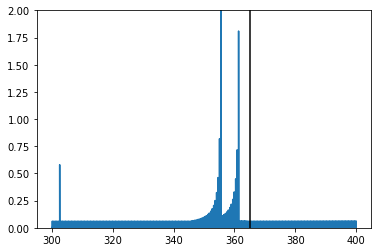

In [131]:
n, bins = np.histogram(tsm[inrabin].mjd, bins=5000)
midbin = (bins[:-1] + bins[1:])/2

frequency, power = LombScargle(midbin, n).autopower(minimum_frequency=300, maximum_frequency=400)

plt.plot(frequency, power)
plt.ylim(0, 2)
plt.axvline(365.25, c='k')

(0, 2)

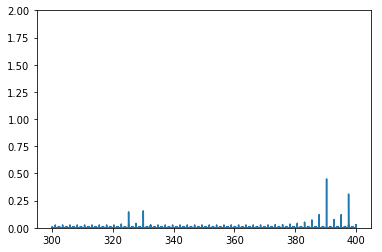

In [136]:
n, bins = np.histogram(tsm[inrabin].mjd, bins=25000)
midbin = (bins[:-1] + bins[1:])/2

frequency, power = LombScargle(midbin, n).autopower(minimum_frequency=300, maximum_frequency=400)

plt.plot(frequency, power)
plt.ylim(0, 2)
#plt.axvline(365.25, c='k')

Hmm doesn't seem to really work due to aliasing?

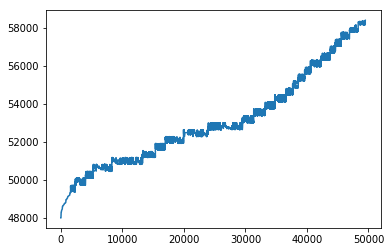

In [139]:
plt.plot(tsm[inrabin].mjd)

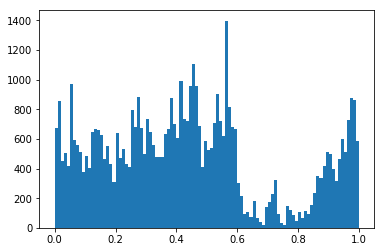

In [145]:
plt.hist(delyear[inrabin], bins=100);

# Try a bayesian model

Model: if you are "inside" the circle(t) you have a probability of q times what uniformly distributied points would give. Circle has radius r, moves  at period p, sinusoidal w/ dec amplitude D, initial phase at t=0 alpha0, delta0

prior forms are (for values on blank ones see code):

q = U(0, 0.1)

r = tN

period = U 

D = U

alpha0 = U(0, 360 deg)

delta0 = U(0, 360 deg)

In [38]:
import emcee
import corner

In [41]:
import math
from scipy import stats

MINF = -np.inf

params = 'q, r, p, D, a0, d0'.split(', ')

r_clip_a, r_clip_b = 15, 70
r_mean = 50
r_std = .2
a, b = (r_clip_a - r_mean) / r_std, (r_clip_b - r_mean) / r_std
r_prior = stats.truncnorm(a=a, b=b, scale=r_std, loc=r_mean)


D_clip_a, D_clip_b = 0, 35
D_mean = 23.5
D_std = 1
a, b = (D_clip_a - D_mean) / D_std, (D_clip_b - D_mean) / D_std
D_prior = stats.truncnorm(a=a, b=b, scale=D_std, loc=D_mean)

def logpri(params):
    q, r, p, D, a0, d0 = params
    
    lpri = 0
    if not 0 < q < 0.1:
        return MINF
    lpri += r_prior.logpdf(r) 
    if not 300 < p < 400:
        return MINF
    lpri += D_prior.logpdf(D)
    if not 0 < a0 < 360:
        return MINF
    if not 0 < d0 < 360:
        return MINF
    
    return lpri


TWOPI = 2*np.pi
D2R = TWOPI/360
def loglike(params, rasd, decsd, mjds):
    q, r, p, D, a0, d0 = params
    
    tau = mjds/p
    ra = (360*tau + a0) %360
    dec = D*np.sin(tau*TWOPI + d0*D2R)
    
    # can approximate if r is reasonably small
    #center = ICRS(u.Quantity(ra, u.deg), u.Quantity(dec, u.deg))
    #incircle = scs.separation(center).deg < r
    dra = rasd - ra#scs.ra.deg - ra
    ddec = decsd - dec#scs.dec.deg - dec
    incircle = np.hypot(dra*np.cos(dec*D2R), ddec) < r
    
    Pin = q * 0.5 * (1-math.cos(r*D2R)) #this is the expected *uniform* fraction for a circle of radius r
    
    return stats.binom.logpmf(np.sum(incircle), len(incircle), Pin)
    
#     lps = np.empty(len(rasd))
#     lps[incircle] = math.log(q)
#     lps[~incircle] = math.log(1-q)
#     return lps


def logprob(params, rasd, decsd, mjds):
    lp = logpri(params)
    if lp == MINF:
        return MINF
    
    lls = loglike(params, rasd, decsd, mjds)
    return lp + lls#np.sum(lls)

In [42]:
nsample = 1000

sampler = emcee.EnsembleSampler(len(params)*5, len(params), logprob, 
                                args=(sc.ra.deg, sc.dec.deg, tsm.mjd), 
                                threads=1)

q_init = np.random.rand(sampler.k)*.1
r_init = -1*np.ones(sampler.k)
while np.sum(r_init < 0) > 0:
    # non-negative draws from r_prioir
    r_init[r_init < 0] = r_prior.rvs(np.sum(r_init < 0))
p_init = np.random.rand(sampler.k)*100 + 300
D_init = np.random.randn(sampler.k)+23.5
a0_init = np.random.rand(sampler.k)*360
d0_init = np.random.rand(sampler.k)*360
pos0 = np.array([q_init, r_init, p_init, D_init, a0_init, d0_init]).T

print('Sampling:')
for results in tqdm.tqdm_notebook(sampler.sample(pos0, iterations=nsample), total=nsample):
    pass

Sampling:


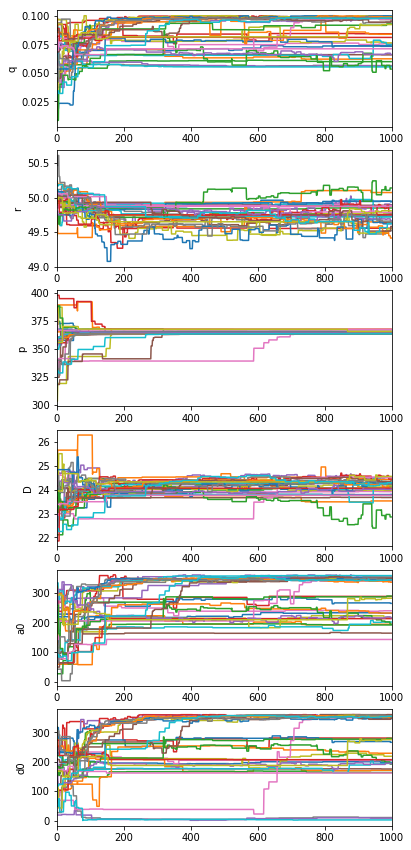

In [43]:
fig, axs = plt.subplots(sampler.dim, 1, figsize=(6, 15))
for pname, subchain, ax in zip(params, sampler.chain.T, axs.ravel()):
    ax.plot(subchain)
    ax.set_xlim(0, sampler.chain.shape[1])
    ax.set_ylabel(pname)

1.0


array([363.47567303, 363.55381402, 364.77711998, 365.09978505,
       365.64424131])

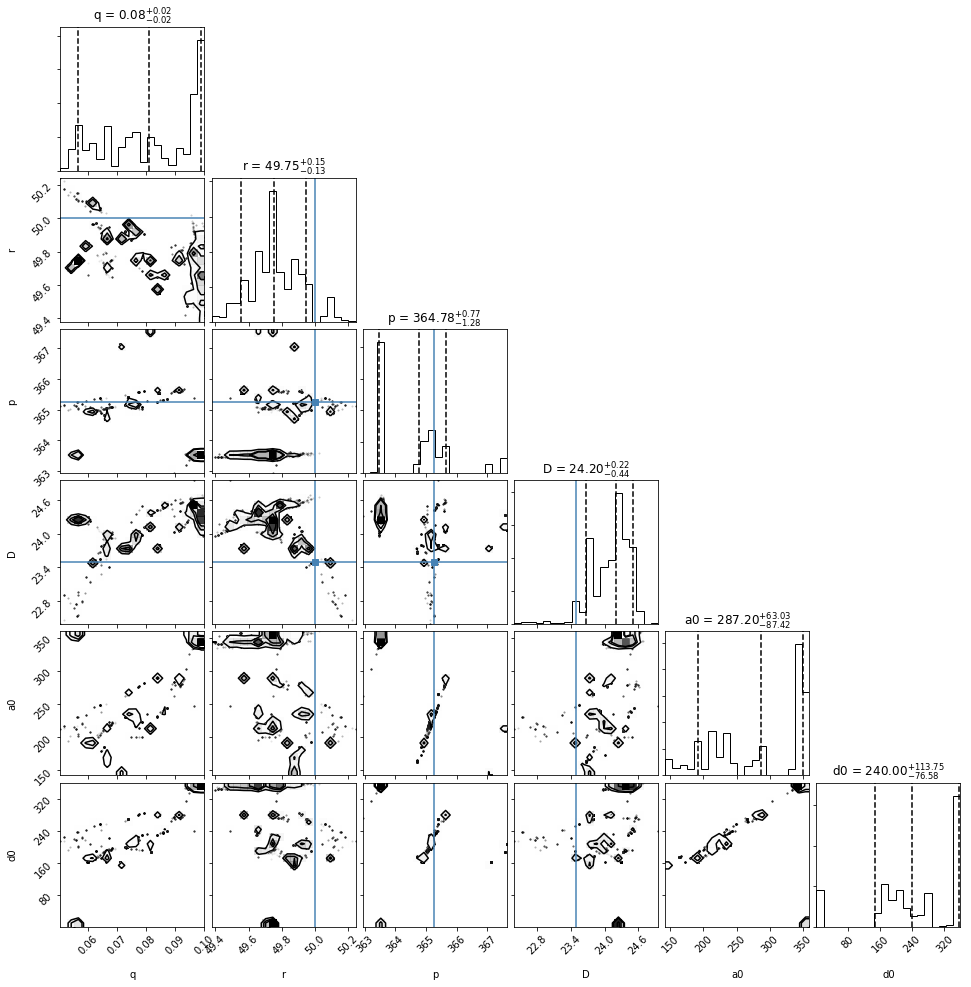

In [60]:
nburnin = 700

unburned_chain = sampler.chain[:, nburnin:, :]
reshaped_chain = unburned_chain.reshape(unburned_chain.size//sampler.dim, sampler.dim)

# select a subset of the chain elements
msk = (364. < reshaped_chain[:, 2])&(reshaped_chain[:, 2] < 366)
# or all of them
msk = np.ones(reshaped_chain.shape[0], dtype=bool)

print(np.sum(msk)/(unburned_chain.size//sampler.dim))

corner.corner(reshaped_chain[msk,:], 
              labels=params,
              truths=[None, 50, 365.25, 23.5, None, None],
              quantiles=[.1, .5, .9], show_titles=True)

np.percentile(unburned_chain.T[2].ravel(), [10, 33, 50, 66, 90])

Curiosity: more threads are *worse* ... memory transfers?

In [83]:
#threads=4

Sampling:


In [81]:
#threads=2

Sampling:


In [79]:
#threads=1

Sampling:
